In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display

import os


#S-1
# Reading and Utilizing Provided Data

In [ ]:
patient_data=pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [ ]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/160_1b4_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.962,6.553,1,1.1
0,6.553,11.160,1,1
1,11.160,15.401,1,1
2,15.401,19.841,1,1


In [ ]:
import os
path='/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b4_Al_mc_AKGC417L',
 '160_1b3_Ar_mc_AKGC417L',
 '160_1b3_Tc_mc_AKGC417L',
 '160_1b3_Pr_mc_AKGC417L',
 '160_1b4_Ar_mc_AKGC417L']

 have various information in txt  ,so we will extract that   

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
getFilenameInfo('160_1b4_Al_mc_AKGC417L')

['160', '1b4', 'Al', 'mc', 'AKGC417L']

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.962,6.553,1,1,160,mc,160_1b4_Al_mc_AKGC417L
1,6.553,11.160,1,1,160,mc,160_1b4_Al_mc_AKGC417L
2,11.160,15.401,1,1,160,mc,160_1b4_Al_mc_AKGC417L
3,15.401,19.841,1,1,160,mc,160_1b4_Al_mc_AKGC417L
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L


In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 0 to 4
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


> Lets get **pid** and **101** to same type and merge both dataframes on pid

In [ ]:
files_df['pid'] = files_df['pid'].str.replace(r'\D', '', regex=True)
files_df['pid'] = files_df['pid'].astype('int32')

In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,1.962,6.553,1,1,160,mc,160_1b4_Al_mc_AKGC417L,COPD
1,6.553,11.160,1,1,160,mc,160_1b4_Al_mc_AKGC417L,COPD
2,11.160,15.401,1,1,160,mc,160_1b4_Al_mc_AKGC417L,COPD
3,15.401,19.841,1,1,160,mc,160_1b4_Al_mc_AKGC417L,COPD
4,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD


In [ ]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

# S-2
# Processing Audio files

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    max_ind = len(raw_data)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

input images to cnn and audio files must be of same length. ( (start - end) must be same )


<Axes: xlabel='None', ylabel='pid'>

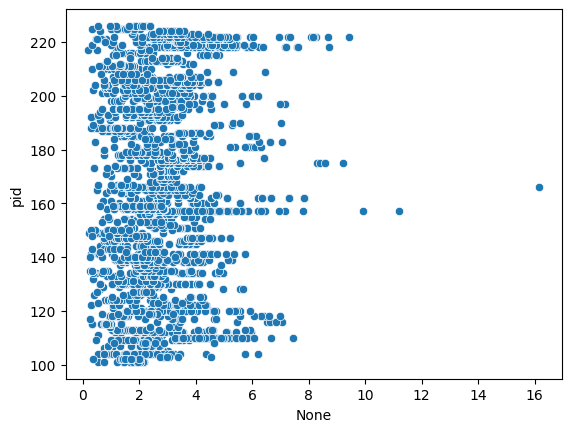

In [ ]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<Axes: ylabel='None'>

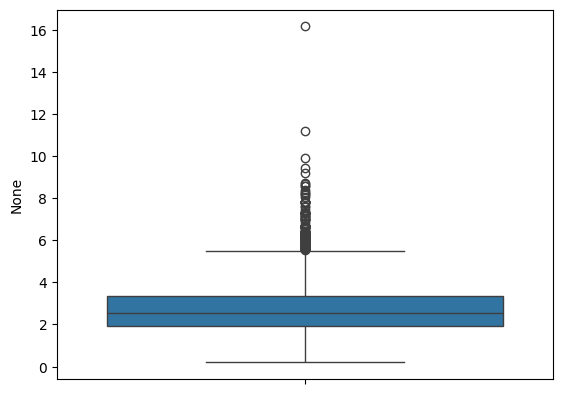

In [ ]:
sns.boxplot(y=(data.end-data.start))

> Lets create a directory for storing our files

In [ ]:
os.makedirs('processed_audio_files')

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        1.962
end                          6.553
crackles                         1
weezels                          1
pid                            160
mode                            mc
filename    160_1b4_Al_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object



 using **Librosa** module for loading audio files and **Soundfile** module for writing to output path



In [ ]:
import librosa as lb
import soundfile as sf
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']


    if end-start>maxLen:
        end=start+maxLen

    audio_file_loc=path + filename + '.wav'

    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'

    save_path='processed_audio_files/' + filename
    c+=1

    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)

    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    if len(pureSample) < reqLen:
        padded_data = np.pad(pureSample, (0, reqLen - len(pureSample)), 'constant')
    else:
        padded_data = pureSample[:reqLen]

    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

Total Files Processed:  6898
